# Import lots of stuff

In [451]:
import sys
sys.path.append('../')

In [452]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [453]:
import math
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import textacy
import textacy.io
from zss import simple_distance
from nltk import Tree
#from utils import nlp_utils as utils
#from nltk import bigrams
from collections import Counter
#from pycorenlp import StanfordCoreNLP
%matplotlib inline
pd.set_option('display.max_rows', 500)

Use the lg spacy corpus 

In [454]:
import spacy
from spacy.lang.en import English
nlp = spacy.load('en_core_web_lg')

# Preprocess data for analyses

## Import annotated file

In [557]:
d_raw = pd.read_csv('../../data/tangrams.csv')
d = d_raw.copy()

## Get list of all game ids

In [456]:
gameidList = pd.unique(d.gameid.ravel()).tolist()
print(gameidList[0:5])
print(len(gameidList))

['7026-d36b3d5a-1ba3-403c-bcbd-31d0d1a0aa6b', '1567-e80221b4-f349-4b3b-9921-224ee47eea1f', '1670-7a1fc24b-6599-4efb-8a98-22ce7368261a', '5108-ab2d0b72-034a-4f00-991a-416faf93c98c', '3419-7061f84e-30ba-48dc-9bc3-133c5fdf8fa3']
137


## Get list of all tangram names

In [457]:
tangramList = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L']
print(tangramList)

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L']


# What are most common words & phrases to reduce? 

Strangely, spacy has no n-gram function, so we use textacy, a convenience wrapper around spacy

In [558]:
d['doc'] = [textacy.Doc(textacy.preprocess_text(row, lowercase = True), lang='en') for row in d['contents']]

KeyboardInterrupt: 

In [84]:
d['unigrams'] = [list(doc.to_terms_list(ngrams=1, as_strings=True, 
                                       normalize = 'lower',filter_stops = False, named_entities = False)) for doc in d['doc']]

d['bigrams'] = [list(doc.to_terms_list(ngrams=2, as_strings=True, 
                                       normalize = 'lower',filter_stops = False, named_entities = False)) for doc in d['doc']]

d['trigrams'] = [list(doc.to_terms_list(ngrams=3, as_strings=True, 
                                       normalize = 'lower',filter_stops = False, named_entities = False)) for doc in d['doc']]

In [88]:
def getCounts(countType, df, gameid, repetitionNum, tangram = None) :
    roundCond = 'repetitionNum == ' + repetitionNum
    gameidCond = 'gameid == "' + gameid + '"'
    if(tangram is not None) :
        tangramCond = 'tangramRef == "' + tangram + '"'
        cond = " and ".join((roundCond, gameidCond, tangramCond))
    else :
        cond = " and ".join((roundCond, gameidCond))
    relevantRow = df.query(cond)
    return Counter([item for sublist in relevantRow[countType]
                    for item in sublist])

for countType in ['unigrams', 'bigrams', 'trigrams'] :
    countDict = Counter([item for sublist in d[countType]
                         for item in sublist])
    wordList = [v for (v,count) in countDict.items() if count > 20]

    with open(countType + 'Counts.csv', 'w') as outfile:
        writer = csv.writer(outfile)
        writer.writerow(['gameid', 'repetitionNum', 'word', 'count'])
        for gameid in gameidList:  
            for repetitionNum in ['1', '2', '3', '4', '5', '6'] :
                counts = getCounts(countType, d, gameid, repetitionNum)
                for word in wordList :
                    writer.writerow([gameid, repetitionNum, word, counts[word]])

# Extract parts of speech

In [180]:
from spacy.attrs import POS

In [559]:
d['doc'] = [nlp(text) for text in d['contents']]

## Get counts for each POS label

In [182]:
tag_dict = {}
for doc in d['doc'] :
    for w in doc :
        if w.pos not in tag_dict :
            tag_dict[w.pos_] = w.pos
d['posCounts'] = [doc.count_by(POS) for doc in d['doc']]
print(tag_dict)
for posStr in ["NOUN", "DET", "PRON", "VERB", "ADJ", "CCONJ", "ADP"] :
    key_id = tag_dict[posStr]
    d[posStr + 'count'] = [counts[key_id] if key_id in counts else 0 for counts in d['posCounts']]

{'INTJ': 90, 'PUNCT': 96, 'PRON': 94, 'VERB': 99, 'PART': 93, 'ADP': 84, 'NOUN': 91, 'ADV': 85, 'DET': 89, 'ADJ': 83, 'CCONJ': 88, 'NUM': 92, 'SYM': 98, 'SPACE': 102, 'PROPN': 95, 'X': 100}


In [183]:
d['tokens'] = [[element.text for element in l] for l in d['doc']]
d['pos'] = [[element.pos_ for element in l] for l in d['doc']]
d['noun_chunks'] = [list(l.noun_chunks) for l in d['doc']]
d['numWords'] = [len(l) for l in d['doc']]

In [184]:
print(d['pos'][3])
print(d['tokens'][3])

['DET', 'NOUN', 'ADV', 'VERB', 'ADP', 'PRON', 'VERB', 'VERB', 'DET', 'ADJ', 'ADV', 'CCONJ', 'VERB', 'ADP', 'DET', 'NOUN', 'PART']
['This', 'one', 'kinda', 'looks', 'like', 'they', 'are', 'looking', 'a', 'little', 'down', 'and', 'kneeling', 'with', 'both', 'arms', 'out']


In [186]:
d.columns

Index(['gameid', 'msgTime', 'trialNum', 'repetitionNum', 'role',
       'intendedName', 'timeElapsed', 'contents', 'totalLength', 'thinksHuman',
       'comments', 'ratePartner', 'nativeEnglish', 'time', 'intendedObj',
       'clickedObj', 'objBox', 'correct', 'numRawWords', 'repetitionScore',
       'taskVersion', 'doc', 'posCounts', 'NOUNcount', 'DETcount', 'PRONcount',
       'VERBcount', 'ADJcount', 'CCONJcount', 'ADPcount', 'tokens', 'pos',
       'noun_chunks', 'numWords', 'nouns'],
      dtype='object')

## Export to csv for plotting in R

In [188]:
(d.drop(["tokens", "nouns"], 1)
 .to_csv("posTagged.csv", index = False))

# Extract constituency parses

In [189]:
from allennlp.models.archival import load_archive
from allennlp.predictors import Predictor
archive = load_archive(
            "https://s3-us-west-2.amazonaws.com/allennlp/models/elmo-constituency-parser-2018.03.14.tar.gz"
        )
predictor = Predictor.from_archive(archive, 'constituency-parser')

<class 'allennlp.modules.text_field_embedders.text_field_embedder.TextFieldEmbedder'>
<class 'allennlp.modules.span_extractors.span_extractor.SpanExtractor'>
<class 'allennlp.modules.seq2seq_encoders.seq2seq_encoder.Seq2SeqEncoder'>
<class 'allennlp.modules.feedforward.FeedForward'>
<class 'allennlp.modules.token_embedders.embedding.Embedding'>
<class 'allennlp.nn.initializers.InitializerApplicator'>


## Compute edit distances on successive rounds

TODO: it would be nice to use an algorithm like Selkow that uses operations for deleting entire subtrees at once (rather than attaching children to parent, which means that deleting a whole subtree requires as many operations as there are *nodes* in that subtree)

see http://www.aclweb.org/anthology/R13-1002 for a way of altering ZS output

In [295]:
def label_distance (label1, label2) :
    if label1 == label2 :
        return 0
    else :
        return 1

def get_root(doc) :
    asdf = dict(('label' if key == 'nodeType' else key, value) for (key, value) in doc.items())
    return asdf

def get_children(subtree) :
    if 'children' in subtree.keys() :
        return [dict(('label' if key == 'nodeType' else key, value) for (key, value) in d.items()) for d in subtree['children']]
    else :
        return []

def get_label(node) :
    return node['label']

def edit_distance(tree1, tree2, return_operations = False) :
    return simple_distance(get_root(tree1), get_root(tree2), 
                           get_children, get_label, label_distance, return_operations=return_operations)

def example() :
    s1 = predictor.predict_json({"sentence": "I am a cat with a big bone"})
    s2 = predictor.predict_json({"sentence": "I am a cat"})
    ed = edit_distance(s1['hierplane_tree']['root'], s2['hierplane_tree']['root'], return_operations=True)
    print('tree1:', Tree.fromstring(s1['trees']))
    print('tree2:', Tree.fromstring(s2['trees']))
    print('operations:', ed[1])
    print('cost:', ed[0])

Ideally, we could use an algorithm that would give a cost of 1 for this example

In [298]:
from IPython.display import clear_output

tiny_d = d.query('role == "director"')[['gameid', 'msgTime', 'repetitionNum', 'contents', 'intendedName', 'taskVersion']]
parses = []
for i, s in enumerate(tiny_d['contents']) :
    clear_output(wait=True)
    print(i, '/', len(tiny_d['contents']))
    parses.append(predictor.predict_json({'sentence' : s})['hierplane_tree']['root'])
tiny_d['tree_parse'] = parses

13314 / 13315


In [304]:
def finditem(obj, value, initLevel = True):
    if obj['nodeType'] == value and not initLevel:
        return True
    elif 'children' in obj :
        for child in obj['children'] :
            item = finditem(child, value, initLevel = False)
            if item is not None:
                return item
tiny_d['SBAR'] = [finditem(s, 'SBAR') for s in tiny_d['tree_parse']]
tiny_d['PP'] = [finditem(s, 'PP') for s in tiny_d['tree_parse']]
tiny_d['CC'] = [finditem(s, 'CC') for s in tiny_d['tree_parse']]

In [305]:
tiny_d.to_json('constituency_parses.json')
tiny_d.drop('tree_parse', 1).to_csv('constituency_tags.csv')

In [310]:
tiny_d = pd.read_json('constituency_parses.json').query('taskVersion == "cued"')

,gameid,msgTime,repetitionNum,contents,intendedName,taskVersion,tree_parse,SBAR,PP,CC
0,7026-d36b3d5a-1ba3-403c-bcbd-31d0d1a0aa6b,1490374558980,1,"Hello, I am going to describe them as people a...",B,cued,"{'word': 'Hello , I am going to describe them ...",NaN,1.0,NaN
1,7026-d36b3d5a-1ba3-403c-bcbd-31d0d1a0aa6b,1490374560623,1,Is that okay?,B,cued,"{'word': 'Is that okay ?', 'nodeType': 'SQ', '...",NaN,NaN,NaN
10,7026-d36b3d5a-1ba3-403c-bcbd-31d0d1a0aa6b,1490374654711,1,This one looks like a woman in a dress who is ...,G,cued,{'word': 'This one looks like a woman in a dre...,1.0,1.0,NaN
100,7026-d36b3d5a-1ba3-403c-bcbd-31d0d1a0aa6b,1490375570591,6,kneeling preach,K,cued,"{'word': 'kneeling preach', 'nodeType': 'S', '...",NaN,NaN,NaN
1000,8505-2fa3d6f9-8e28-49ed-8cd1-de703e113a82,1490384733375,2,is it sexist that im assuming all these shapes...,D,cued,{'word': 'is it sexist that i m assuming all t...,1.0,NaN,NaN


In [312]:
gameids = np.unique(tiny_d['gameid'])
tangramids = np.unique(tiny_d['intendedName'])

transitions = np.zeros([len(gameids), len(tangramids) ,5])
for i, gameid in enumerate(gameids) :
    clear_output(wait=True)
    print(i, '/', len(gameids))
    game_d = tiny_d.query('gameid == "{0}"'.format(gameid))
    for j, intendedName in enumerate(tangramids) :
        for k, init_occurrenceNum in enumerate(range(1,6)) :
            dist = []
            sub1 = game_d.query('intendedName == "{0}" and repetitionNum == {1}'.format(intendedName, init_occurrenceNum))['tree_parse']
            sub2 = game_d.query('intendedName == "{0}" and repetitionNum == {1}'.format(
                intendedName, init_occurrenceNum+1
            ))['tree_parse']
            for tree1 in sub1 :
                for tree2 in sub2 :
                    dist.append(edit_distance(tree1, tree2))
            transitions[i, j, k] = np.max(dist) if dist else np.nan

82 / 83


In [313]:
np.nanmean(transitions, axis=0)

array([[24.27710843, 14.24096386,  7.65060241,  3.56626506,  3.89156627],
       [24.79518072, 16.6626506 , 11.04819277,  7.5060241 ,  5.98795181],
       [15.5       ,  7.25301205,  4.3253012 ,  2.3373494 ,  3.25301205],
       [19.73493976, 12.10843373,  7.40963855,  4.07228916,  3.31325301],
       [17.19277108,  7.54216867,  4.26506024,  2.31325301,  2.19277108],
       [18.36144578, 13.68674699,  7.24096386,  4.61445783,  3.24096386],
       [25.58536585, 16.4939759 ,  9.14457831,  5.80722892,  5.62650602],
       [21.79268293, 11.53012048,  6.48192771,  4.31325301,  3.62650602],
       [21.10843373, 12.24096386,  7.3253012 ,  4.75903614,  2.87951807],
       [22.52439024, 13.51807229,  7.5060241 ,  4.95180723,  3.54216867],
       [25.57317073, 17.86585366, 11.4939759 ,  6.62650602,  5.60240964],
       [21.14457831, 13.63855422,  9.21686747,  6.03614458,  4.97590361]])

### Across-game version
Instead of looking at edit distance from round $i$ to $i + 1$ for pair $j$, we look at average edit distances between pairs $j$ to $j+1$ on round $i$.

In [330]:
import random
print(random.sample([1,2], len([1,2])))

[2, 1]


In [344]:
acrossgame = np.zeros([len(tangramids),6, len(gameids)])
shuffled_gameids = random.sample(list(gameids), len(gameids))
for i, intendedName in enumerate(tangramids) :
    clear_output(wait=True)
    print(i, '/', len(tangramids))
    for repetitionNum in range(1,7) :
        mini_d = tiny_d.query('intendedName == "{0}" and repetitionNum == {1}'.format(intendedName, repetitionNum))      
        for k in range(len(gameids) -1) :
            dist = []
#            print(gameids[k], 'to', gameids[k+1])
            sub1 = mini_d.query('gameid == "{0}"'.format(gameids[k]))['tree_parse']
            sub2 = mini_d.query('gameid == "{0}"'.format(gameids[k+1]))['tree_parse']
            for tree1 in sub1 :
                for tree2 in sub2 :
                    dist.append(edit_distance(tree1, tree2))
#             print(sub1)
#             print(sub2)
            acrossgame[i, repetitionNum-1, k] = np.max(dist) if dist else np.nan

11 / 12


In [346]:
np.nanmean(acrossgame, axis=2)

array([[31.13253012, 21.38554217, 14.6626506 ,  9.96385542,  9.09638554,
         8.75903614],
       [31.79518072, 23.97590361, 17.51807229, 11.84337349, 10.20481928,
         9.3373494 ],
       [21.95061728, 12.69879518,  9.91566265,  6.20481928,  6.55421687,
         7.46987952],
       [27.43373494, 17.73493976, 13.46987952,  8.75903614,  8.19277108,
         8.07228916],
       [24.74698795, 14.63855422,  9.59036145,  6.38554217,  5.22891566,
         5.34939759],
       [24.87951807, 18.73493976, 13.15662651, 10.81927711,  9.08433735,
         8.34939759],
       [31.13580247, 23.55421687, 15.81927711, 12.08433735, 10.37349398,
         9.79518072],
       [28.86419753, 18.86746988, 13.84337349, 10.30120482,  9.10843373,
         7.57831325],
       [28.45783133, 19.12048193, 13.07228916,  9.61445783,  8.40963855,
         7.81927711],
       [27.48148148, 19.55421687, 14.3253012 , 10.87951807,  7.78313253,
         8.1686747 ],
       [31.97590361, 24.59259259, 18.19277108, 12.

# Calculate indicator words for tangrams/rounds

## First, get list of words in first round

In [ ]:
# Filter down to first round
d_round1 = d[d['occurrenceNum'] == 1]

# Pull out all tokens and collapse into count dict
tokenDict = Counter([item for sublist in d_round1['tokens'].tolist()
                     for item in sublist])
# Pull out all words that occur more than once
wordList = [word for (word,count) in tokenDict.items() if count > 1 and not word.isdigit()]
print(wordList[0:10])
print(len(wordList))

# Get POS map; will be longer because it doesn't require count > 1, but it doesn't matter
POSdict = {word: POS for lemma in d_round1['lemmas'] for (word, POS) in lemma}
print(len(POSdict.keys()))

## Helper functions to select words & counts

In [ ]:
def getWordCounts(df, gameid, occurrenceNum, tangram = None) :
    roundCond = 'occurrenceNum == ' + occurrenceNum
    gameidCond = 'gameid == "' + gameid + '"'
    if(tangram is not None) :
        tangramCond = 'intendedObj == "' + tangram + '"'
        cond = " and ".join((roundCond, gameidCond, tangramCond))
    else :
        cond = " and ".join((roundCond, gameidCond))
    relevantRow = df.query(cond)
    return Counter([item for sublist in relevantRow['tokens'].tolist() 
                    for item in sublist])

#creates mini dataframe that grabs the words used in round n for a given tangram and gameid
def selectTangramRoundWords(df, tangram, roundNum, gameid):
    wordCounts = getWordCounts(df, gameid, roundNum, tangram)
    return list(wordCounts.keys())

## Helper function to compute PMIs

Note that merging is really costly -- if we need to speed it up, this might be the first target. Can also vectorize the log operation.

In [ ]:
#returns a table with the all words above 0 PMI and their counts for a given tangram
#calculate the probability for words given tangram A ------ p(x|y)
def makeMyPMI(df, tangram, roundNum, gameid, totals):

    # count words w/in tangram
    tangramCounts = getWordCounts(df, gameid, roundNum, tangram)

    #total number of words 
    tangramNumWords = (1 if sum(tangramCounts.values()) == 0 
                       else sum(tangramCounts.values()))

    #dataframe to compare 
    indicatorDF = pd.merge(pd.DataFrame(list(tangramCounts.items()), columns=['word', 'count']),
                           pd.DataFrame(list(totals["counts"].items()), columns=['word', 'totalCount']),
                           on='word', how = 'inner')

    #calculate PMI without log first. Having trouble with float issues. 
    indicatorDF['roughPMI'] = ((indicatorDF['count']/tangramNumWords)
                                / (indicatorDF['totalCount']/totals["numWords"]))
    indicatorDF['logPMI'] = [math.log10(num) for num in indicatorDF['roughPMI']]
    
    #remove column rough PMI
    indicatorDF = indicatorDF.drop('roughPMI', 1)
    
    return indicatorDF

## Write out PMIs & matching rates for all words

Note that we do a sloppy optimization by only computing total counts once and only when necessary 

In [ ]:
def memoize(d, gameid, counts) : 
    if "counts" not in counts : 
        counts["counts"] = getWordCounts(d, gameid, "1")
        counts["numWords"] = float(sum(counts["counts"].values()))
        return counts
    else :
        return counts

with open('sequential_matchAndPMI.csv', 'a', newline='') as outfile:
    writer = csv.writer(outfile)
    writer.writerow(['word', 'POS', 'match', 'pmi', 'total'])
    for word in wordList :
        print(word + ":" + POSdict[word])
        pmi = 0
        match = 0
        total = 0
        for gameid in gameidList:  
            memoizedCounts = {}
            for tangram in tangramList:
                memoizedCounts = memoize(d, gameid, memoizedCounts)
                round1WordList = selectTangramRoundWords(d, tangram, "1", gameid)
                total = total + 1 if word in round1WordList else total
                if word in round1WordList :
                    PMI_df = makeMyPMI(d, tangram, "1", gameid, memoizedCounts)
                    pmi = pmi + PMI_df[PMI_df['word'] == word]['logPMI'].tolist()[0]
                    round6WordList = selectTangramRoundWords(d, tangram, "6", gameid)
                    match = (match + 1 if (word in round1WordList and word in round6WordList)
                             else match)
        writer.writerow([word, POSdict[word], float(match) / float(total), pmi/total, total])


Also write out raw word counts on each round (so we can see what most likely words to be dropped are).

In [ ]:
for row in d :
    print row

TODO: exclude numbers earlier in the pipeline, 

TODO: don't average over matches and pmis

In [ ]:
numSamples = 1000

#grab words with highestPMI for a given tangram/gameid
def highestPMIWords(d, tangram, roundNum, gameid):
    allTangramCounts = {}
    allTangramCounts['counts'] = getWordCounts(d, gameid, "1")
    allTangramCounts['numWords'] = float(sum(allTangramCounts["counts"].values()))

    PMIdf = (makeMyPMI(d, tangram, roundNum, gameid, allTangramCounts))

    # Remove numbers
    PMIdf['POS'] = [POSdict[word] for word in PMIdf['word']]
    PMIdf = PMIdf.query('POS != "CD"'.format())

    #if PMIdf has words, pull out max values, it is empty return it as is
    if len(PMIdf.index) > 0:
        PMI_values = PMIdf.logPMI.unique()
        maxPMI = PMI_values.max()
        PMIdf = PMIdf.loc[PMIdf['logPMI'] == maxPMI]
        PMIdfword = PMIdf['word']
        return PMIdfword.tolist()
    else: 
        return PMIdf

with open('PMIbootstrap.csv', 'w', newline='') as outfile:
    writer = csv.writer(outfile)
    writer.writerow(['sampleNum', 'tangram', 'gameid', 'numCandidates', 'match', 'highest'])
    for gameid in gameidList :
        for tangram in tangramList :
            round1Words = selectTangramRoundWords(d, tangram, "1", gameid)
            if len(round1Words) > 0:
                # First, write highest PMI match
                highPMIWords = highestPMIWords(d, tangram, "1", gameid)
                round6Words = selectTangramRoundWords(d, tangram, "6", gameid)
                match = np.mean([1 if word in round6Words else 0 for word in highPMIWords ])
                writer.writerow([0, tangram, gameid, len(highPMIWords), match, "highest"])

                # Next, take a bunch of null samples
                for i in range(numSamples) :
                    randomWord = np.random.choice(round1Words)
                    match = np.mean([1 if randomWord in round6Words else 0])
                    writer.writerow([i + 1, tangram, gameid, 1, match, "null"])

# Examine semantic embeddings

We'd like to pull out bag of words embeddings from NPs in each utterance in the cued dataset and cluster them for each tangram; expect to see different pairs in different parts of the space (i.e. to compute a d' for an 'idiosyncracy' or 'multiple equilibria' result) and also different utterances from single games closer together. 

In [597]:
embedding_meta = (d
               .query("taskVersion == 'cued' and role == 'director'")
               .sort_values(by = ['gameid', 'intendedName', 'repetitionNum'])
               .loc[:, ['gameid', 'intendedName', 'repetitionNum', 'doc']])

In [633]:
meta = pd.DataFrame(columns = ['gameid', 'intendedName', 'repetitionNum'])
feats = np.array([]).reshape(0, 300)

for name, group in (embedding_meta.groupby(['gameid', 'intendedName', 'repetitionNum'], as_index=False)) :
    embedding = np.array([]).reshape(0, 300)
    for doc in group.doc :
        for token in doc :
            if token.pos_ == 'NOUN' and token.has_vector :
                embedding = np.vstack((embedding, token.vector))
    new_df = pd.DataFrame([list(name)], columns = ['gameid', 'intendedName', 'repetitionNum'])
    meta = meta.append(pd.DataFrame([list(name)], columns = ['gameid', 'intendedName', 'repetitionNum']),
                ignore_index=True)
    feats = np.vstack((feats, np.nanmean(embedding, axis = 0)))

/Users/rxdh/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: Mean of empty slice
  del sys.path[0]


array([[-0.05938999, -0.11493666, -0.36205868, ...,  0.29572667,
         0.04859334,  0.092505  ],
       [-0.117     , -0.58921999,  0.33151001, ...,  0.30081001,
        -0.052732  , -0.27913001],
       [-0.117     , -0.58921999,  0.33151001, ...,  0.30081001,
        -0.052732  , -0.27913001],
       ...,
       [ 0.07215634,  0.22266426, -0.094039  , ...,  0.01851333,
         0.00478666, -0.48152766],
       [ 0.07215634,  0.22266426, -0.094039  , ...,  0.01851333,
         0.00478666, -0.48152766],
       [-0.24610551,  0.27184099, -0.34189499, ..., -0.06555501,
         0.09834199, -0.15535499]])

In [638]:
print(feats.shape)
print(meta.shape)

(5971, 300)
(5971, 3)


TODO: do we really only want to use nouns? or all words in noun_chunks?

TODO: do for rest of tangrams

TODO: check whether *tangrams* cluster together?

In [ ]:
## save stuff out so just in case we mess up it's okay
meta.to_csv('meta_tangrams_embeddings.csv')
np.save('feats_tangrams_embeddings.npy',feats)

In [756]:
import scipy.spatial.distance as distance

In [762]:
## for each tangram, grab feats from all games and get distance matrix
tangram_ids = np.unique(meta.intendedName.values)

this_tangram = tangram_ids[0]

this_meta = meta[meta['intendedName']==this_tangram]
tangram_inds = np.array(this_meta.index)
these_feats = feats[tangram_inds,:]

## get distance matrix for this tangram
dist_mat = distance.pdist(these_feats, metric='euclidean') ## or some other distance metric
dist_mat_sq = distance.squareform(dist_mat)

## then for each game, compare the within-game distances to the distances to utts from a different game
## yielding, for each pair of games, a measure of the extent to which the within-game distances are SMALLER
## than the between-game distances

## handy experiment parameters
num_reps_per_game = len(np.unique(meta.repetitionNum.values))
assert dist_mat_sq.shape[0]%num_reps_per_game==0 ## check ot make sure that this is divisible by the number of reps in each game
num_games = int(dist_mat_sq.shape[0]/num_reps_per_game)

In [763]:
# ## loop through game_inds
# for game_ind1 in range(len(gameids)):
#     for game_ind2 in range(game_ind1, len(gameids)):
        
dist_ratio = []
for game_ind in np.arange(num_games):
    # extract the within-game distances
    lb = game_ind * num_reps_per_game
    ub = (game_ind+1) * num_reps_per_game
    within_game_dist_block = dist_mat_sq[lb:ub,lb:ub]

    ## get the indices of the upper triangle of this block
    triu_inds = np.triu_indices(num_reps_per_game,k=1)
    ## now grab actual distances 
    within_game_dists = within_game_dist_block[triu_inds]

    ## loop through game_inds again to get between-game distances
    other_games = [i for i in np.arange(num_games) if i != game_ind]
    
    _dist_ratio = [] ## initialize the dist ratio list for this game_ind
    for this_other_game_ind in other_games:

        ## get indices for the other game
        lbo = this_other_game_ind * num_reps_per_game
        ubo = (this_other_game_ind+1) * num_reps_per_game

        ## now, extract the between-game distances
        between_game_dist_block = dist_mat_sq[lb:ub,lbo:ubo]
        between_game_dists = np.ravel(between_game_dist_block)
        assert len(between_game_dists)==num_reps_per_game**2 ## so here there really should be 36 distances to consider

        ## doop, derp, um, we could compute the ratio? um
        avg_within_game_dist = np.mean(within_game_dists)
        avg_between_game_dist = np.mean(between_game_dists)
        _dist_ratio.append(avg_within_game_dist/avg_between_game_dist)
        
    ## tack on your list of dist ratios for this game_ind onto your cumulative dist_ratio list of lists
    dist_ratio.append(_dist_ratio)

In [764]:
dist_ratio = np.array(dist_ratio)
agg_dr = np.nanmean(dist_ratio,axis=1)

/Users/rxdh/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  


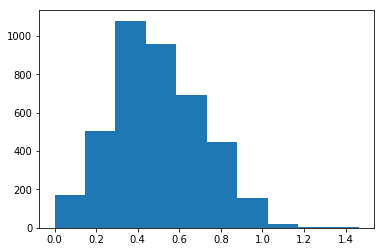

In [765]:
def remove_nans(x):
    return [i for i in x if not np.isnan(i)]
    
x = remove_nans(np.ravel(dist_ratio))
j = plt.hist(x)

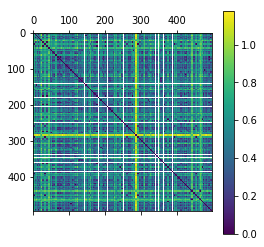

In [671]:
plt.matshow(dist_mat_sq)
plt.colorbar()

# Look at tsne visualization

In [465]:
from sklearn import manifold
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)

In [478]:
def plot_embedding(X, y, title=None):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    plt.figure()
    ax = plt.subplot(111)
    for i in range(X.shape[0]):
        plt.scatter(X[i, 0], X[i, 1], 
                 color=plt.cm.Set1(y[i]))

    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)


TODO: there are a bunch of problems with this: a lot of the creative utterances don't exist in current embedding (e.g. "ghostman"), sometimes they don't converge to a noun (e.g. "flying"), etc.

In [766]:
embedding_d = d.query('taskVersion == "cued" and intendedName == "A"')
X = embedding_d[embedding_d['noun_embedding'].notna()]['noun_embedding']
str_y = embedding_d[embedding_d['noun_embedding'].notna()]['gameid']
str_dict = dict([(y,x+1) for x,y in enumerate(sorted(set(str_y)))])
y = [str_dict[v] for v in str_y]
X_tsne = tsne.fit_transform(np.stack(X.values))
plot_embedding(X_tsne, np.array(y))

AttributeError: module 'scipy.spatial.distance' has no attribute 'query'

TODO: compare cosine similarity distances with-in vs. across games?

In [492]:
embedding_d = d.query('taskVersion == "cued" and intendedName == "F"')
X = embedding_d[embedding_d['noun_embedding'].notna()]
X

,gameid,msgTime,trialNum,repetitionNum,role,intendedName,timeElapsed,contents,totalLength,thinksHuman,...,time,intendedObj,clickedObj,objBox,correct,numRawWords,repetitionScore,taskVersion,doc,noun_embedding
5,7026-d36b3d5a-1ba3-403c-bcbd-31d0d1a0aa6b,1.490375e+12,2.0,1,director,F,5062.0,Good job1 This one is sitting down,1309306.0,yes,...,1.490375e+12,F,F,5.0,1.0,7,12,cued,"(Good, job1, This, one, is, sitting, down)","[0.05407100170850754, 0.11110000312328339, -0...."
6,7026-d36b3d5a-1ba3-403c-bcbd-31d0d1a0aa6b,1.490375e+12,2.0,1,director,F,2478.0,iwth his knees up,1309306.0,yes,...,1.490375e+12,F,F,5.0,1.0,4,12,cued,"(iwth, his, knees, up)","[-0.4622899889945984, -0.47690001130104065, -0..."
39,7026-d36b3d5a-1ba3-403c-bcbd-31d0d1a0aa6b,1.490375e+12,18.0,2,director,F,14857.0,laying on his back with a hump,1309306.0,yes,...,1.490375e+12,F,F,5.0,1.0,7,12,cued,"(laying, on, his, back, with, a, hump)","[0.14362100884318352, 0.007645003497600555, -0..."
40,7026-d36b3d5a-1ba3-403c-bcbd-31d0d1a0aa6b,1.490375e+12,18.0,2,director,F,6660.0,he has a square head and his feet are on the l...,1309306.0,yes,...,1.490375e+12,F,F,5.0,1.0,13,12,cued,"(he, has, a, square, head, and, his, feet, are...","[0.22798666854699454, 0.0033709328078354397, -..."
63,7026-d36b3d5a-1ba3-403c-bcbd-31d0d1a0aa6b,1.490375e+12,33.0,3,director,F,995.0,on ground,1309306.0,yes,...,1.490375e+12,F,F,12.0,1.0,2,12,cued,"(on, ground)","[0.33098000288009644, 0.12464000284671783, 0.0..."
127,1567-e80221b4-f349-4b3b-9921-224ee47eea1f,1.490376e+12,12.0,1,director,F,9872.0,man sitting facing west,NaN,NaN,...,1.490376e+12,F,F,7.0,1.0,4,8,cued,"(man, sitting, facing, west)","[0.023685000836849213, 0.11508250329643488, 0...."
139,1567-e80221b4-f349-4b3b-9921-224ee47eea1f,1.490376e+12,21.0,2,director,F,5183.0,guy that is sitting facing west,NaN,NaN,...,1.490376e+12,F,F,5.0,1.0,6,11,cued,"(guy, that, is, sitting, facing, west)","[-0.16911501437425613, 0.05380350071936846, 0...."
155,1567-e80221b4-f349-4b3b-9921-224ee47eea1f,1.490376e+12,34.0,3,director,F,2159.0,sitting guy,NaN,NaN,...,1.490376e+12,F,F,1.0,1.0,2,10,cued,"(sitting, guy)","[-0.5587000250816345, 0.08407200127840042, -0...."
162,1567-e80221b4-f349-4b3b-9921-224ee47eea1f,1.490376e+12,40.0,4,director,F,1398.0,sitting guy,NaN,NaN,...,1.490376e+12,F,F,9.0,1.0,2,10,cued,"(sitting, guy)","[-0.5587000250816345, 0.08407200127840042, -0...."
179,1567-e80221b4-f349-4b3b-9921-224ee47eea1f,1.490377e+12,51.0,5,director,F,9031.0,sitting guy,NaN,NaN,...,1.490377e+12,F,F,5.0,1.0,2,11,cued,"(sitting, guy)","[-0.5587000250816345, 0.08407200127840042, -0...."
